In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from collections import Counter

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [ ]:
##The dataset is loaded to your GDrive so need to be mounted
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Colab Notebooks/project/Copy of trainval.zip'
extract_path = '/content/project22'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [2]:
import os
import cv2

def read_data(data_path, data_type):
    """
    Read data from the specified path based on the data type.

    Parameters:
    - data_path: str
        Path to the directory containing the data.
    - data_type: str
        Type of data to read ('before', 'after', or 'label').

    Returns:
    - data: list of numpy.ndarray or None
        List of images read from the specified path. Returns None if data_type is invalid.

    Note:
    This function reads images from the specified directory based on the data type provided.
    It reads images from subdirectories 'A' for 'before' data, 'B' for 'after' data, and 'label'
    for label data.

    Example:
    data_path = 'data'
    data_type = 'before'
    before_images = read_data(data_path, data_type)
    """

    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    file_names = sorted(os.listdir(data_path), key=lambda x: int(x.split('.')[0]))
    for file_name in file_names:
        img = cv2.imread(os.path.join(data_path, file_name))
        data.append(img)
    return data


In [3]:
def display_images(before, after, labels):
    """
    Display images representing the before state, after state, and labels.

    Parameters:
    - before: numpy.ndarray
        Image representing the before state.
    - after: numpy.ndarray
        Image representing the after state.
    - labels: numpy.ndarray
        Array representing the labels.

    Returns:
    None

    Note:
    This function displays three images side by side using Matplotlib:
    - Before state image
    - After state image
    - Labels

    Example:
    before = np.array([[...]])
    after = np.array([[...]])
    labels = np.array([[...]])
    display_images(before, after, labels)
    """

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()


In [4]:
def plot_row(images, titles):
    """
    Plot a row of images with corresponding titles.

    Parameters:
    - images: list of numpy.ndarray
        List of images to plot.
    - titles: list of str
        List of titles corresponding to each image.

    Returns:
    None

    Note:
    This function plots a row of images side by side with their corresponding titles.

    Example:
    images = [image1, image2, image3]
    titles = ['Title 1', 'Title 2', 'Title 3']
    plot_row(images, titles)
    """

    # Create subplots
    fig, ax = plt.subplots(1, len(images), figsize=(10, 20))

    # Plot the first image
    ax[0].imshow(images[0].astype("uint8"))
    ax[0].set_title(titles[0])
    ax[0].axis("off")

    # Plot the remaining images with titles
    for i in range(len(images) - 1):
        ax[i + 1].imshow(images[i + 1])
        ax[i + 1].set_title(titles[i + 1])
        ax[i + 1].axis("off")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [5]:
training_path = 'trainval'

In [6]:
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')
labels = read_data(training_path,'label')

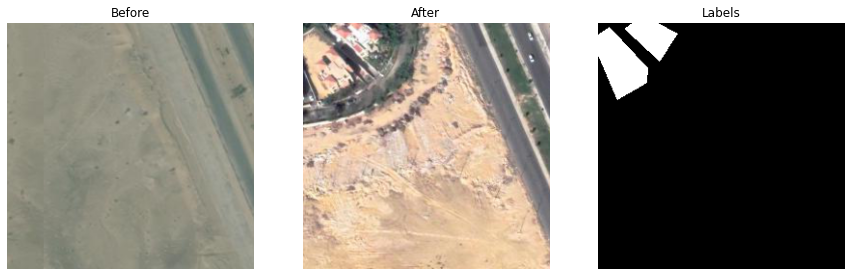

In [7]:
index = 2
# print first image in before_images, after_images, and labels in the same row
display_images(before_images[index], after_images[index], labels[index])

## PCA with Kmeans

In [8]:
def find_vector_set(diff_image, new_size):
    """
    Create a vector set from a difference image.

    Parameters:
    - diff_image: numpy.ndarray
        The difference image from which to create the vector set.
    - new_size: tuple
        A tuple containing the new size dimensions (height, width) of the image.

    Returns:
    - vector_set: numpy.ndarray
        A 2D array representing the vector set derived from the difference image.
    - mean_vec: numpy.ndarray
        A 1D array containing the mean vector computed from the vector set.

    Note:
    The function divides the new image size into non-overlapping blocks of size 5x5,
    and each block is flattened into a 1D array to form the feature vector. The function
    then computes the mean vector and performs mean normalization on the vector set.

    Example:
    diff_image = np.array([[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15]])
    new_size = (3, 5)
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    """

    # Initialize variables
    i = 0
    j = 0

    # Initialize the vector set with zeros
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 25), 25))

    # Iterate over the vector set
    while i < vector_set.shape[0]:
        while j < new_size[1]:
            k = 0
            while k < new_size[0]:
                # Extract a 5x5 block from the difference image
                block = diff_image[j:j+5, k:k+5]

                # Flatten the block into a 1D feature vector
                feature = block.ravel()

                # Assign the feature vector to the current row of the vector set
                vector_set[i, :] = feature

                k += 5  # Move to the next block horizontally
            j += 5  # Move to the next block vertically
        i += 1  # Move to the next row in the vector set

    # Compute the mean vector across the vector set
    mean_vec = np.mean(vector_set, axis=0)

    # Mean normalization
    vector_set = vector_set - mean_vec

    return vector_set, mean_vec


In [9]:
def find_FVS(EVS, diff_image, mean_vec, new):
    """
    Find the Feature Vector Space (FVS) from Eigen Vector Space (EVS) and a difference image.

    Parameters:
    - EVS: numpy.ndarray
        Eigen Vector Space obtained from some previous computation.
    - diff_image: numpy.ndarray
        The difference image from which to extract features.
    - mean_vec: numpy.ndarray
        Mean vector computed from the vector set.
    - new: tuple
        A tuple containing the dimensions (height, width) of the new image.

    Returns:
    - FVS: numpy.ndarray
        The Feature Vector Space derived from the difference image and the Eigen Vector Space.

    Note:
    The function iterates over the difference image, extracting 5x5 blocks centered at each pixel,
    flattening them into feature vectors, and appending them to a feature vector set. The Feature Vector
    Space (FVS) is then computed by dot-producting this feature vector set with the Eigen Vector Space (EVS).
    Finally, mean normalization is applied to the FVS using the provided mean vector.

    Example:
    EVS = np.array([[0.1, 0.2], [0.3, 0.4]])
    diff_image = np.array([[1, 2, 3], [4, 5, 6]])
    mean_vec = np.array([0.5, 0.6])
    new = (2, 3)
    FVS = find_FVS(EVS, diff_image, mean_vec, new)
    """

    # Initialize variables
    i = 2
    feature_vector_set = []

    # Iterate over the difference image
    while i < new[1] - 2:
        j = 2
        while j < new[0] - 2:
            # Extract a 5x5 block from the difference image centered at (i,j)
            block = diff_image[i - 2:i + 3, j - 2:j + 3]

            # Flatten the block into a feature vector
            feature = block.flatten()

            # Append the feature vector to the feature vector set
            feature_vector_set.append(feature)
            j += 1
        i += 1

    # Compute the Feature Vector Space (FVS) by dot-producting the feature vector set with EVS
    FVS = np.dot(feature_vector_set, EVS)

    # Mean normalization of FVS
    FVS = FVS - mean_vec

    return FVS


In [10]:
def clustering(FVS, components, new):
    """
    Perform clustering on the Feature Vector Space (FVS) using K-Means algorithm.

    Parameters:
    - FVS: numpy.ndarray
        Feature Vector Space derived from the difference image and Eigen Vector Space.
    - components: int
        Number of clusters to form.
    - new: tuple
        A tuple containing the dimensions (height, width) of the new image.

    Returns:
    - least_index: int
        The index of the cluster with the least number of elements.
    - change_map: numpy.ndarray
        A 2D array representing the change map obtained from clustering.

    Note:
    The function utilizes the K-Means clustering algorithm to cluster the feature vectors
    in the Feature Vector Space (FVS) into 'components' clusters. It then identifies the cluster
    with the least number of elements and generates a change map by reshaping the cluster labels.

    Example:
    FVS = np.array([[0.1, 0.2], [0.3, 0.4]])
    components = 2
    new = (2, 2)
    least_index, change_map = clustering(FVS, components, new)
    """

    # Initialize KMeans clustering model
    kmeans = KMeans(components, verbose=0)

    # Fit KMeans model to the Feature Vector Space (FVS)
    kmeans.fit(FVS)

    # Predict cluster labels for the feature vectors
    output = kmeans.predict(FVS)

    # Count the occurrences of each cluster label
    count = Counter(output)

    # Find the index of the cluster with the least number of elements
    least_index = min(count, key=count.get)

    # Reshape the cluster labels into a change map
    change_map = np.reshape(output, (new[1] - 4, new[0] - 4))

    return least_index, change_map


In [11]:
# Define the output directory
out_dir = "output"

# Check if the output directory exists, if not, create it
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [12]:
def display_images(before, after, labels, predicted_label):
    """
    Display images representing the before state, after state, ground truth labels, and predicted labels.

    Args:
    - before: numpy.ndarray
        Image representing the before state.
    - after: numpy.ndarray
        Image representing the after state.
    - labels: numpy.ndarray
        Array representing the ground truth labels.
    - predicted_label: numpy.ndarray
        Array representing the predicted labels.

    Returns:
    None

    Note:
    This function displays four images side by side using Matplotlib:
    - Before state image
    - After state image
    - Ground truth labels
    - Predicted labels

    Example:
    before = np.array([[...]])
    after = np.array([[...]])
    labels = np.array([[...]])
    predicted_label = np.array([[...]])
    display_images(before, after, labels, predicted_label)
    """

    # Convert images to uint8
    before = before.astype(np.uint8)
    after = after.astype(np.uint8)
    labels = labels.astype(np.uint8)
    predicted_label = predicted_label.astype(np.uint8)

    # Create subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Display the before state image
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')

    # Display the after state image
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')

    # Display the ground truth labels
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')

    # Display the predicted labels
    axs[3].imshow(predicted_label, cmap='gray')
    axs[3].set_title('Predicted Labels')
    axs[3].axis('off')

    plt.show()


In [13]:
def increase_saturation(before_images, after_images, factor):
    """
    Increases the saturation of a list of images using the HSV color space.

    Args:
    - before_images: list of NumPy arrays
        List of images representing the before state (RGB).
    - after_images: list of NumPy arrays
        List of images representing the after state (RGB).
    - factor: float
        Factor to increase the saturation by.

    Returns:
    - preprocessed_images_A: list of NumPy arrays
        List of images with increased saturation representing the before state (RGB).
    - preprocessed_images_B: list of NumPy arrays
        List of images with increased saturation representing the after state (RGB).

    Note:
    This function iterates over the pairs of before and after images, converts them to the HSV color space,
    increases the saturation by the specified factor, and then converts them back to the RGB color space.
    Finally, the images are scaled to the range [0, 255] and returned as lists.

    Example:
    before_images = [image1_before, image2_before]
    after_images = [image1_after, image2_after]
    factor = 1.5
    enhanced_before_images, enhanced_after_images = increase_saturation(before_images, after_images, factor)
    """

    preprocessed_images_A = []
    preprocessed_images_B = []

    # Iterate over pairs of before and after images
    for image_A, image_B in zip(before_images, after_images):
        # Convert the images to the HSV color space
        hsv_image_A = color.rgb2hsv(image_A)
        hsv_image_B = color.rgb2hsv(image_B)

        # Increase the saturation by the specified factor
        hsv_image_A[:, :, 1] *= factor
        hsv_image_B[:, :, 1] *= factor

        # Convert back to the RGB color space
        enhanced_image_A = color.hsv2rgb(hsv_image_A)
        enhanced_image_B = color.hsv2rgb(hsv_image_B)

        # Scale the images to the range [0, 255]
        enhanced_image_A = (enhanced_image_A * 255).astype(np.uint8)
        enhanced_image_B = (enhanced_image_B * 255).astype(np.uint8)

        # Append the preprocessed images to the lists
        preprocessed_images_A.append(enhanced_image_A)
        preprocessed_images_B.append(enhanced_image_B)

    return preprocessed_images_A, preprocessed_images_B


In [14]:
def preprocess_images(before_images, after_images, gamma_values):
    """
    Preprocesses a list of before and after satellite images using gamma correction.

    Args:
    - before_images: List of NumPy arrays representing the before images (RGB).
    - after_images: List of NumPy arrays representing the after images (RGB).
    - gamma_values: List of gamma values to apply for gamma correction.

    Returns:
    - preprocessed_images_A: List of preprocessed before images.
    - preprocessed_images_B: List of preprocessed after images.

    Note:
    This function applies gamma correction to each pair of before and after images using
    the specified gamma values. It returns lists of preprocessed before and after images.

    Example:
    before_images = [image1_before, image2_before]
    after_images = [image1_after, image2_after]
    gamma_values = [1.1, 1.2]
    preprocessed_before, preprocessed_after = preprocess_images(before_images, after_images, gamma_values)
    """

    preprocessed_images_A = []
    preprocessed_images_B = []

    for gamma in gamma_values:
        for image_A, image_B in zip(before_images, after_images):

            # Gamma Correction
            corrected_image_A = exposure.adjust_gamma(image_A, gamma)
            corrected_image_B = exposure.adjust_gamma(image_B, gamma)

            # Append preprocessed images to the lists
            preprocessed_images_A.append(corrected_image_A)
            preprocessed_images_B.append(corrected_image_B)

    return preprocessed_images_A, preprocessed_images_B


In [15]:
def calculate_iou(mask1, mask2):
    """
    Calculate the Intersection over Union (IoU) score between two binary masks.

    Args:
    - mask1: numpy.ndarray
        Binary mask representing the first object.
    - mask2: numpy.ndarray
        Binary mask representing the second object.

    Returns:
    - iou_score: float
        Intersection over Union (IoU) score between the two masks.

    Note:
    This function calculates the IoU score between two binary masks. IoU is computed
    as the ratio of the area of overlap between the masks to the area of their union.

    Example:
    mask1 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    mask2 = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    iou = calculate_iou(mask1, mask2)
    """

    # Compute the intersection and union of the masks
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)

    # Calculate the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score


Jaccard index (IOU) for pair 0: 0.7185565046200743


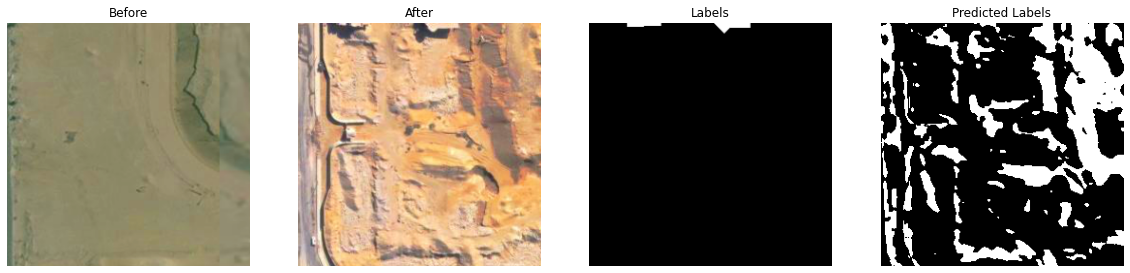

Jaccard index (IOU) for pair 1: 0.7777597718286122


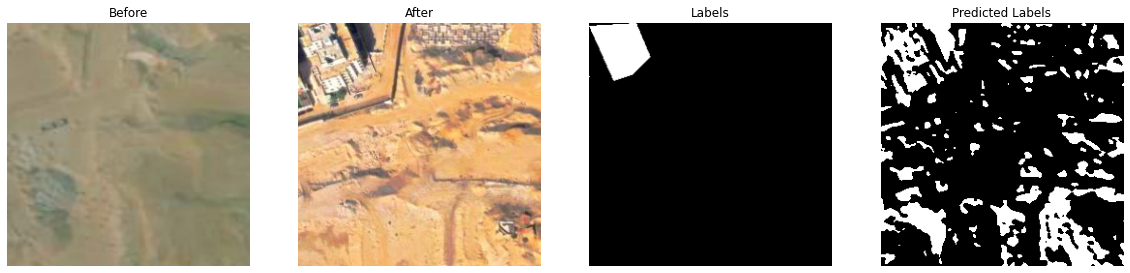

Jaccard index (IOU) for pair 2: 0.7359912740533324


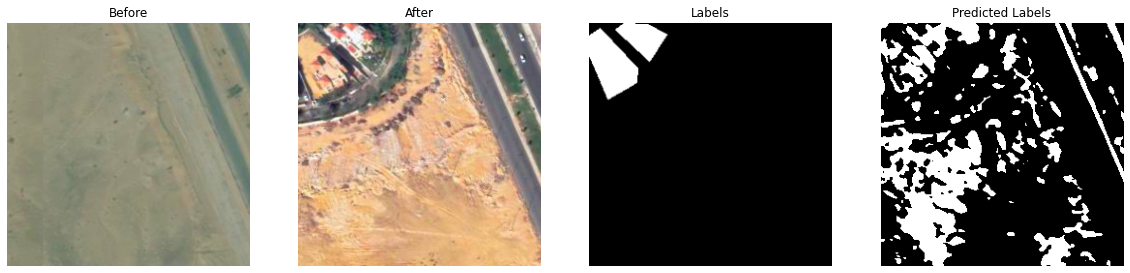

Jaccard index (IOU) for pair 3: 0.8051732396615041


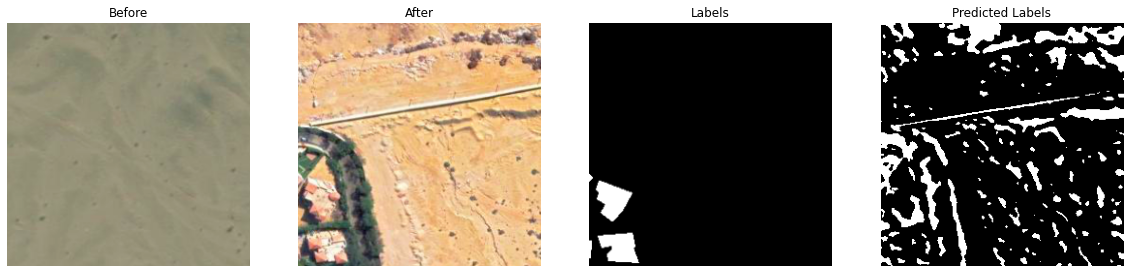

Jaccard index (IOU) for pair 4: 0.7607815748956366


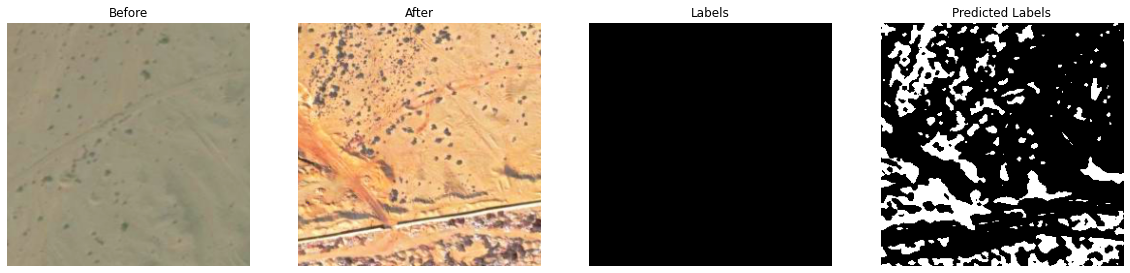

In [16]:
# Define the number of images to process
num_images = min(5, len(before_images))

# Define the preprocessing parameters
factor = 1.5
gamma_values = [1]

# Preprocess the last 5 images
before_images_last = before_images[num_images - 5:num_images]
after_images_last = after_images[num_images - 5:num_images]

before_images_processed, after_images_processed = increase_saturation(before_images_last, after_images_last, factor)
before_images_processed, after_images_processed = preprocess_images(before_images_processed, after_images_processed, gamma_values)

# Ensure that the processed images list contains the correct number of elements
num_processed_images = len(before_images_processed)
assert num_processed_images == 5, "Number of processed images should be 5"

# Iterate over pairs of images and apply change detection
iou_scores = []
for i in range(num_images - 5, num_images):
    # Apply change detection code here for each pair of images
    image1 = before_images_processed[i - (num_images - 5)]
    image2 = after_images_processed[i - (num_images - 5)]
    label = labels[i]

    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores.append(iou)

    # Print Jaccard index for each pair
    print(f'Jaccard index (IOU) for pair {i}: {iou}')

    # Display images
    display_images(image1, image2, label_resized, change_map)


In [17]:
# take the first 5 images
before_images2 = before_images
after_images2 = after_images
labels2 = labels

In [19]:
# Define the preprocessing parameters
factor = 1.5
gamma_values = [1]

before_images_processed, after_images_processed = increase_saturation(before_images2, after_images2, factor)
before_images_processed, after_images_processed = preprocess_images(before_images_processed, after_images_processed, gamma_values)

# Split data into training and testing sets
before_train, before_test, after_train, after_test, labels_train, labels_test = train_test_split(
    before_images_processed, after_images_processed, labels2, test_size=0.33, random_state=49)

# Initialize a list to store the IOU scores
iou_scores_train = []
iou_scores_test = []

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
scaler = StandardScaler()

In [20]:
# Now, iterate over the training and testing sets to perform change detection
for i in range(len(before_train)):
    image1 = before_train[i]
    image2 = after_train[i]
    label = labels_train[i]

    # Perform change detection on training data
    # (code block from the previous snippet)
    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # Clustering
    least_index, change_map = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
    change_map = change_map.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_inverted = np.logical_not(change_map)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_inverted, label_binary_inverted)
    union = np.logical_or(change_map_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores_train.append(iou)

    # Print Jaccard index for each pair in training set
    print(f'Jaccard index (IOU) for pair {i} in Training: {iou}')

    # Display images
    #display_images(image1, image2, label_resized, change_map)

    # fit the model on the training data
    X_train = FVS
    y_train = label_binary_inverted
    # reshape the label to a column vector
    y_train = y_train.reshape(-1, 1)
    X_train_scaled = scaler.fit_transform(X_train)
    #clf = KMeans(n_clusters=3)
    clf.fit(X_train_scaled, y_train)


Jaccard index (IOU) for pair 0 in Training: 0.8767162425993238


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 1 in Training: 0.7713687084331995


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 2 in Training: 0.8120188568435421


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 3 in Training: 0.7689084300249203


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 4 in Training: 0.6436382034208121


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 5 in Training: 0.782447904353406


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 6 in Training: 0.9249059538737481


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 7 in Training: 0.7402226662860405


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 8 in Training: 0.9177093688937643


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 9 in Training: 0.5818648749051087


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 10 in Training: 0.8821606006253869


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 11 in Training: 0.8639704131680449


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 12 in Training: 0.9863335502611069


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 13 in Training: 0.6222484977080938


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 14 in Training: 0.5657134034413546


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 15 in Training: 0.8380025713877558


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 16 in Training: 0.8037015285471659


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 17 in Training: 0.7145918318756845


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 18 in Training: 0.7920350470627451


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 19 in Training: 0.7802415834669291


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 20 in Training: 0.732512182346312


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 21 in Training: 0.7812627517898876


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 22 in Training: 0.26525173388132545


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 23 in Training: 0.922826621799654


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 24 in Training: 0.6164736164736164


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 25 in Training: 0.8914302947572261


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 26 in Training: 0.8906049110331582


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 27 in Training: 0.552629570261812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 28 in Training: 0.9049062713290266


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 29 in Training: 0.844034221679021


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 30 in Training: 0.9465087855748322


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 31 in Training: 0.9597466706877669


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 32 in Training: 0.9270011587117665


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 33 in Training: 0.7821304423739306


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 34 in Training: 0.7824637704163426


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 35 in Training: 0.7582216808769793


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 36 in Training: 0.7762416469579848


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 37 in Training: 0.6679634312390585


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 38 in Training: 0.7349518993117609


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 39 in Training: 0.9403818987000206


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 40 in Training: 0.8618593355661022


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 41 in Training: 0.8560975222615514


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 42 in Training: 0.6803066617990191


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 43 in Training: 0.8849859526039269


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 44 in Training: 0.7077347978603514


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 45 in Training: 0.7775183826448775


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 46 in Training: 0.7794161997428612


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 47 in Training: 0.7732563212173033


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 48 in Training: 0.8145267535435945


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 49 in Training: 0.8225901176171807


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 50 in Training: 0.6484508572615566


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 51 in Training: 0.8887001793622323


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 52 in Training: 0.8350184917699719


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 53 in Training: 0.8048602403136458


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 54 in Training: 0.8332883605022142


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 55 in Training: 0.9159537150203965


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 56 in Training: 0.8868906842748527


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 57 in Training: 0.9563340264440247


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 58 in Training: 0.8225336322869955


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 59 in Training: 0.5363815222516707


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 60 in Training: 0.7063697401628546


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 61 in Training: 0.9588577959080015


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 62 in Training: 0.9611752194409613


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 63 in Training: 0.8780336820050475


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 64 in Training: 0.7894477865430708


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 65 in Training: 0.62411674600168


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 66 in Training: 0.637579752260662


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 67 in Training: 0.8240027936064507


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 68 in Training: 0.7698607958603831


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 69 in Training: 0.5298346974803403


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 70 in Training: 0.8361295852446786


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 71 in Training: 0.7797971460770464


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 72 in Training: 0.958142192733218


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 73 in Training: 0.587759448205715


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 74 in Training: 0.8021972780462987


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 75 in Training: 0.7054576956396188


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 76 in Training: 0.7601942826304344


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 77 in Training: 0.9008269710004603


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 78 in Training: 0.7243218361613307


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 79 in Training: 0.8605561211504199


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 80 in Training: 0.8207647497658768


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 81 in Training: 0.8876187383291386


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 82 in Training: 0.846732591546166


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 83 in Training: 0.7363986519017814


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 84 in Training: 0.678104628689357


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 85 in Training: 0.844452959113623


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 86 in Training: 0.8203361851399185


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 87 in Training: 0.8795098490500151


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 88 in Training: 0.7705433247091316


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 89 in Training: 0.8369073506769734


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 90 in Training: 0.6551266507192712


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 91 in Training: 0.6336963484945548


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 92 in Training: 0.790622371073475


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 93 in Training: 0.9398104791987428


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 94 in Training: 0.853129315407692


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 95 in Training: 0.6483774623309507


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 96 in Training: 0.7540515229916985


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 97 in Training: 0.5142145606261522


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 98 in Training: 0.8142410437929557


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 99 in Training: 0.7563412147090689


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 100 in Training: 0.8950651576959096


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 101 in Training: 0.8085109760162537


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 102 in Training: 0.8703210899529918


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 103 in Training: 0.847192901699973


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 104 in Training: 0.9791431882033619


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 105 in Training: 0.9345883398676211


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 106 in Training: 0.8602193353574569


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 107 in Training: 0.5808886454660597


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 108 in Training: 0.8673830574117871


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 109 in Training: 0.7897017507658609


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 110 in Training: 0.9642227901144427


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 111 in Training: 0.9186044665957683


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 112 in Training: 0.7510833161378391


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 113 in Training: 0.8904938016856875


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 114 in Training: 0.9286677989238266


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 115 in Training: 0.7772420774496852


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 116 in Training: 0.8229551911874414


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 117 in Training: 0.794066760845066


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 118 in Training: 0.782479643180267


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 119 in Training: 0.8925413882319329


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 120 in Training: 0.8603038047015127


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 121 in Training: 0.7524088148313035


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 122 in Training: 0.7597735066592233


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 123 in Training: 0.9442548530975698


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 124 in Training: 0.7498611133156616


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 125 in Training: 0.8535420072697258


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 126 in Training: 0.8507007825272614


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 127 in Training: 0.910826812272821


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 128 in Training: 0.4258336722244815


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 129 in Training: 0.6063893424732835


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 130 in Training: 0.834399453976921


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 131 in Training: 0.7578347125816033


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 132 in Training: 0.8870017936223235


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 133 in Training: 0.7634852755369812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 134 in Training: 0.9399215885462135


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 135 in Training: 0.9357311788701766


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 136 in Training: 0.9308106220536182


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 137 in Training: 0.916302915826733


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 138 in Training: 0.7010093445217954


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 139 in Training: 0.926937667656069


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 140 in Training: 0.7542737416866399


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 141 in Training: 0.6520789853909135


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 142 in Training: 0.9608260186346248


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 143 in Training: 0.8796844494531832


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 144 in Training: 0.8356534023269472


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 145 in Training: 0.76953125


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 146 in Training: 0.7446876648330947


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 147 in Training: 0.7906954543284912


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 148 in Training: 0.7801654811056393


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 149 in Training: 0.779781273313122


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 150 in Training: 0.7572102030126506


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 151 in Training: 0.6913756122546979


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 152 in Training: 0.7712696004046535


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 153 in Training: 0.8012888684306598


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 154 in Training: 0.9249535721655212


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 155 in Training: 0.8157172108379233


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 156 in Training: 0.8516531483627244


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 157 in Training: 0.7624640878716211


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 158 in Training: 0.8465579911429977


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 159 in Training: 0.9531436008952239


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 160 in Training: 0.8747638926366248


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 161 in Training: 0.7690354121363153


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 162 in Training: 0.8813987079570166


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 163 in Training: 0.9453024555165791


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 164 in Training: 0.879345813618597


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 165 in Training: 0.6601230729784302


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 166 in Training: 0.7669243345343725


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 167 in Training: 0.8297011158553039


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 168 in Training: 0.913736006332488


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 169 in Training: 0.8157330836018476


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 170 in Training: 0.8233202647577023


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 171 in Training: 0.8766368787797019


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 172 in Training: 0.7206076094030254


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 173 in Training: 0.8625577371787749


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 174 in Training: 0.6412212398713374


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 175 in Training: 0.7960984746273869


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 176 in Training: 0.6110889440174869


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 177 in Training: 0.761257757813368


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 178 in Training: 0.6150168866554633


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 179 in Training: 0.9017634640719988


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 180 in Training: 0.6617209631728045


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 181 in Training: 0.9917302899953969


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 182 in Training: 0.796338636435807


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 183 in Training: 0.8816209266519579


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 184 in Training: 0.9682068538594626


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 185 in Training: 0.8266694179457469


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 186 in Training: 0.7711941080300313


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 187 in Training: 0.8966365613244234


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 188 in Training: 0.7801780924112316


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 189 in Training: 0.8461452992809638


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 190 in Training: 0.8724305963397406


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 191 in Training: 0.8532404247551626


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 192 in Training: 0.8197488928747163


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 193 in Training: 0.8165584673259154


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 194 in Training: 0.9643180266979889


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 195 in Training: 0.9170489357311788


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 196 in Training: 0.7766384660560943


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 197 in Training: 0.9081284424056761


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 198 in Training: 0.6916215304006814


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 199 in Training: 0.789955714988651


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 200 in Training: 0.8187489087474802


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 201 in Training: 0.812714717603408


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 202 in Training: 0.7751146807193536


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 203 in Training: 0.9796193711210933


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 204 in Training: 0.8481045081967213


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 205 in Training: 0.7497339791947908


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 206 in Training: 0.9493976286090697


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 207 in Training: 0.7622577419406041


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 208 in Training: 0.8277170203647561


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 209 in Training: 0.8143838986682751


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 210 in Training: 0.7586228790019206


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 211 in Training: 0.8695258805415788


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 212 in Training: 0.9702544404057079


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 213 in Training: 0.8815256900684116


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 214 in Training: 0.7837699024139703


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 215 in Training: 0.8872240123172648


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 216 in Training: 0.6494854143947656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 217 in Training: 0.8338756527674164


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 218 in Training: 0.9755083252646783


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 219 in Training: 0.9335883557403851


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 220 in Training: 0.8279074935318487


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 221 in Training: 0.8349550007142744


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 222 in Training: 0.7911599550778117


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 223 in Training: 0.7917493373121062


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 224 in Training: 0.6194700130585725


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 225 in Training: 0.4935577481137551


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 226 in Training: 0.6556639782269574


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 227 in Training: 0.7987440381558029


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 228 in Training: 0.8655418167965588


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 229 in Training: 0.9223980571736956


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 230 in Training: 0.7629879155560643


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 231 in Training: 0.7761840651753659


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 232 in Training: 0.7133366267482071


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 233 in Training: 0.7633864796965567


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 234 in Training: 0.9093347724639291


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 235 in Training: 0.8795068885776635


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 236 in Training: 0.9494769924286917


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 237 in Training: 0.3907141621995504


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 238 in Training: 0.7977174965476739


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 239 in Training: 0.7509087157346709


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 240 in Training: 0.7217411158406315


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 241 in Training: 0.8829066205298328


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 242 in Training: 0.7646069110014126


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 243 in Training: 0.7477341629497944


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 244 in Training: 0.9261757749876987


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 245 in Training: 0.8383517721940922


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 246 in Training: 0.8404469770321106


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 247 in Training: 0.8505502604733748


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 248 in Training: 0.9579054300725385


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 249 in Training: 0.9545086585927207


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 250 in Training: 0.7922096474659133


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 251 in Training: 0.882081236805765


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 252 in Training: 0.8675735305788796


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 253 in Training: 0.561965811965812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 254 in Training: 0.7429088427167823


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 255 in Training: 0.8345740543800892


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 256 in Training: 0.9430802685671656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 257 in Training: 0.6695328677218966


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 258 in Training: 0.5620487804878049


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 259 in Training: 0.7830941762006335


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 260 in Training: 0.9203504706274503


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 261 in Training: 0.839383501849177


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 262 in Training: 0.7710988714464849


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 263 in Training: 0.8679544769130648


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 264 in Training: 0.9119061602196791


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 265 in Training: 0.8767797336550214


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 266 in Training: 0.8000984111363312


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 267 in Training: 0.862272027428136


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 268 in Training: 0.6142813352048142


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 269 in Training: 0.8823034555007063


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 270 in Training: 0.7550832526467833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 271 in Training: 0.827297588464407


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 272 in Training: 0.9056999095252456


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 273 in Training: 0.8737004174536912


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 274 in Training: 0.8326208318664186


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 275 in Training: 0.8596530213806131


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 276 in Training: 0.8563991047761147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 277 in Training: 0.8893985809749052


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 278 in Training: 0.8719067951302361


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 279 in Training: 0.8219234615323566


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 280 in Training: 0.7992095363565658


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 281 in Training: 0.5538236649347761


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 282 in Training: 0.6859395532194481


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 283 in Training: 0.7841939016841003


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 284 in Training: 0.7830726595100819


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 285 in Training: 0.9447945270709989


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 286 in Training: 0.9422707576070221


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 287 in Training: 0.767654481674894


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 288 in Training: 0.8680179679687624


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 289 in Training: 0.8650021428231298


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 290 in Training: 0.8476373390898557


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 291 in Training: 0.8058284789130331


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 292 in Training: 0.7528293201695211


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 293 in Training: 0.9450961095855621


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 294 in Training: 0.9054300725385311


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 295 in Training: 0.6700857102711817


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 296 in Training: 0.888811288709703


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 297 in Training: 0.7510991889017634


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 298 in Training: 0.6962210301904959


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 299 in Training: 0.931175695623879


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 300 in Training: 0.40942174145299143


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 301 in Training: 0.6107658716829023


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 302 in Training: 0.76332258999676


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 303 in Training: 0.734131204266599


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 304 in Training: 0.8525578959064142


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 305 in Training: 0.8452038822196312


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 306 in Training: 0.4960580147846394


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 307 in Training: 0.803003126934493


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 308 in Training: 0.4003030590017994


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 309 in Training: 0.4593264797406279


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 310 in Training: 0.7908128442405676


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 311 in Training: 0.876430532848685


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 312 in Training: 0.765908477643212


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 313 in Training: 0.47583412774070544


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 314 in Training: 0.49492762072928986


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 315 in Training: 0.7983365343407247


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 316 in Training: 0.9603180901890446


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 317 in Training: 0.7014783621539289


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 318 in Training: 0.34396529726971165


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 319 in Training: 0.7927493214393422


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 320 in Training: 0.6599060144241752


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 321 in Training: 0.9793654068983032


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 322 in Training: 0.8900493642958048


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 323 in Training: 0.9754130886811321


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 324 in Training: 0.5741690870828043


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 325 in Training: 0.812383930413803


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 326 in Training: 0.8529388422405993


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 327 in Training: 0.5497900218377288


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 328 in Training: 0.797765114839447


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 329 in Training: 0.8936619151163727


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 330 in Training: 0.7682576467040205


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 331 in Training: 0.9304455484833574


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 332 in Training: 0.880001904731671


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 333 in Training: 0.7288773194076285


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 334 in Training: 0.8039713655338804


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 335 in Training: 0.8967635434358184


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 336 in Training: 0.8355264202155521


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 337 in Training: 0.7730988397009572


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 338 in Training: 0.850430945540547


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 339 in Training: 0.9416675925778956


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 340 in Training: 0.9240646973857558


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 341 in Training: 0.7779241599339694


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 342 in Training: 0.9150646627053478


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 343 in Training: 0.8310979190806496


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 344 in Training: 0.9771908382406629


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 345 in Training: 0.7367343375501976


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 346 in Training: 0.8222091712829955


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 347 in Training: 0.8070506817352106


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 348 in Training: 0.889684290725544


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 349 in Training: 0.8963349788098601


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 350 in Training: 0.9266202123775813


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 351 in Training: 0.617038632210911


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 352 in Training: 0.6227608008429927


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 353 in Training: 0.7637204315486162


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 354 in Training: 0.7921779019380645


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 355 in Training: 0.9116363232329645


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 356 in Training: 0.5345394998330657


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 357 in Training: 0.8923509150648402


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 358 in Training: 0.8525578959064142


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 359 in Training: 0.850764273582959


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 360 in Training: 0.7014932894361111


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 361 in Training: 0.910493484230409


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 362 in Training: 0.7742416787035127


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 363 in Training: 0.8468437008936366


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 364 in Training: 0.784019301280932


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 365 in Training: 0.8491452516626721


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 366 in Training: 0.8871763940254916


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 367 in Training: 0.9604926905922129


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 368 in Training: 0.8427415501258323


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 369 in Training: 0.9099855557848288


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 370 in Training: 0.5166082376858923


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 371 in Training: 0.8703353915017222


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 372 in Training: 0.8033682005047539


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 373 in Training: 0.7549087247571277


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 374 in Training: 0.79473341692989


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 375 in Training: 0.6613471538040504


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 376 in Training: 0.9001603149156363


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 377 in Training: 0.5913843970571759


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 378 in Training: 0.47187957348944176


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 379 in Training: 0.834859764130728


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 380 in Training: 0.9620164759289536


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 381 in Training: 0.566713751557956


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 382 in Training: 0.8797638132728052


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 383 in Training: 0.8771969316548631


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 384 in Training: 0.8128601133315344


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 385 in Training: 0.7048459548261139


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 386 in Training: 0.8730178886049428


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 387 in Training: 0.843081855843558


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 388 in Training: 0.6658945177426394


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 389 in Training: 0.5468400247654427


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 390 in Training: 0.633188769687286


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 391 in Training: 0.9364813226234111


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 392 in Training: 0.6732279973754677


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 393 in Training: 0.6316697705410993


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 394 in Training: 0.5710787904154023


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 395 in Training: 0.7696209596664314


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 396 in Training: 0.826383708195108


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 397 in Training: 0.8405422136156568


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 398 in Training: 0.7823685338327963


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 399 in Training: 0.6910868077112884


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 400 in Training: 0.8232885192298535


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 401 in Training: 0.8153521372676624


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 402 in Training: 0.9223028205901493


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 403 in Training: 0.8406374501992032


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 404 in Training: 0.7839166338969721


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 405 in Training: 0.9336359740321583


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 406 in Training: 0.7933969691005708


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 407 in Training: 0.5703273985993814


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 408 in Training: 0.631808772156812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 409 in Training: 0.9183663751369026


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 410 in Training: 0.7664005333248679


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 411 in Training: 0.8110029999523817


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 412 in Training: 0.8690338248599229


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 413 in Training: 0.4818096045288088


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 414 in Training: 0.9267630672529007


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 415 in Training: 0.656305247077805


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 416 in Training: 0.8384745202428797


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 417 in Training: 0.9491119188584308


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 418 in Training: 0.9016385611235848


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 419 in Training: 0.8770495706417358


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 420 in Training: 0.8417961619656831


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 421 in Training: 0.9816987031951874


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 422 in Training: 0.8500499992063618


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 423 in Training: 0.9244297709560165


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 424 in Training: 0.9672227424961508


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 425 in Training: 0.8004476119426676


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 426 in Training: 0.8070824272630593


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 427 in Training: 0.9592069967143378


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 428 in Training: 0.8153997555594356


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 429 in Training: 0.9174140093014397


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 430 in Training: 0.8201615847367502


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 431 in Training: 0.8686183834773477


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 432 in Training: 0.9133664545007222


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 433 in Training: 0.9067223261839643


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 434 in Training: 0.8335933690882497


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 435 in Training: 0.9189695401660292


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 436 in Training: 0.8005111029983651


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 437 in Training: 0.814950304852585


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 438 in Training: 0.8011777590831891


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 439 in Training: 0.9268741766003714


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 440 in Training: 0.761051411882351


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 441 in Training: 0.89300169838574


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 442 in Training: 0.8497484166917986


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 443 in Training: 0.9193153251244937


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 444 in Training: 0.7615593403279313


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 445 in Training: 0.9505635815208763


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 446 in Training: 0.7826488403013739


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 447 in Training: 0.7363216456881637


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 448 in Training: 0.7185654784805044


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 449 in Training: 0.8114950556340376


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 450 in Training: 0.7095389805097452


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 451 in Training: 0.7433157762728869


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 452 in Training: 0.7740829510642688


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 453 in Training: 0.6031887897601226


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 454 in Training: 0.9554451516642593


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 455 in Training: 0.7704163425977365


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 456 in Training: 0.8833828034475644


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 457 in Training: 0.4118297941583272


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 458 in Training: 0.7845748480182855


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 459 in Training: 0.9334455008650656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 460 in Training: 0.5274550470168938


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 461 in Training: 0.8390977920985381


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 462 in Training: 0.9186520848875415


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 463 in Training: 0.7729083665338645


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 464 in Training: 0.756927595453965


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 465 in Training: 0.7413374390882684


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 466 in Training: 0.8278281297122267


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 467 in Training: 0.9145727845589753


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 468 in Training: 0.8323201219028269


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 469 in Training: 0.7403692004888811


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 470 in Training: 0.8018743992310157


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 471 in Training: 0.5689946074701426


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 472 in Training: 0.7804003111061729


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 473 in Training: 0.4835328372694921


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 474 in Training: 0.7238358419567262


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 475 in Training: 0.9786036941180253


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 476 in Training: 0.7207822098061936


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 477 in Training: 0.877636862906938


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 478 in Training: 0.7578609863335503


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 479 in Training: 0.9090649354772147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 480 in Training: 0.7296868303677719


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 481 in Training: 0.8842875509912541


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 482 in Training: 0.9245250075395629


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 483 in Training: 0.881747908763353


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 484 in Training: 0.6305437779103322


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 485 in Training: 0.8123521848859542


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 486 in Training: 0.8775866487282977


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 487 in Training: 0.6800695572288662


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 488 in Training: 0.9251122998047651


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 489 in Training: 0.9374295646100855


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 490 in Training: 0.7525436104188823


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 491 in Training: 0.8666846557991142


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 492 in Training: 0.7046396088950969


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 493 in Training: 0.8284312947413534


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 494 in Training: 0.8357327661465691


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 495 in Training: 0.8136378787638291


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 496 in Training: 0.5375808453648657


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 497 in Training: 0.677514638680868


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 498 in Training: 0.7587181155854669


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 499 in Training: 0.9449373819463183


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 500 in Training: 0.7749559530801099


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 501 in Training: 0.7569244932620117


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 502 in Training: 0.7595911176013079


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 503 in Training: 0.7168384770557682


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 504 in Training: 0.9018587006555452


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 505 in Training: 0.6413541299682926


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 506 in Training: 0.8488519800565276


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 507 in Training: 0.7575276582911382


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 508 in Training: 0.649977241693218


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 509 in Training: 0.8497801622196474


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 510 in Training: 0.6992799323040569


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 511 in Training: 0.8859224456754655


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 512 in Training: 0.7716226726559896


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 513 in Training: 0.8058919699687307


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 514 in Training: 0.9594970071289078


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 515 in Training: 0.910033174076602


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 516 in Training: 0.8277963841843781


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 517 in Training: 0.8395422294884208


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 518 in Training: 0.8958111776003556


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 519 in Training: 0.6871940440576557


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 520 in Training: 0.9402866621164744


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 521 in Training: 0.9734131204266598


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 522 in Training: 0.7946869270906783


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 523 in Training: 0.9665560864113268


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 524 in Training: 0.7684957381628863


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 525 in Training: 0.8852557895906414


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 526 in Training: 0.9622069490960461


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 527 in Training: 0.9506039586673227


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 528 in Training: 0.942683449469056


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 529 in Training: 0.7442494581556317


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 530 in Training: 0.6267860216904803


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 531 in Training: 0.9153981682830431


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 532 in Training: 0.818701290455707


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 533 in Training: 0.8636460292794634


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 534 in Training: 0.6326560780513444


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 535 in Training: 0.8600498404787226


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 536 in Training: 0.5835721107927412


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 537 in Training: 0.8164632307423692


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 538 in Training: 0.7895213289711908


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 539 in Training: 0.5509460135167831


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 540 in Training: 0.7913207726861479


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 541 in Training: 0.9051602355518167


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 542 in Training: 0.6440323977382711


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 543 in Training: 0.8348756368946525


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 544 in Training: 0.8160981571721084


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 545 in Training: 0.9490484278027332


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 546 in Training: 0.9497627021793305


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 547 in Training: 0.7601625371025856


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 548 in Training: 0.6550632405379043


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 549 in Training: 0.6960683163759306


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 550 in Training: 0.8461294265170394


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 551 in Training: 0.8884462151394422


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 552 in Training: 0.7786543070744909


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 553 in Training: 0.900525388485897


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 554 in Training: 0.9348423040904112


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 555 in Training: 0.9090649354772147


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 556 in Training: 0.762876779733655


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 557 in Training: 0.46070722176660717


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 558 in Training: 0.7992467163535965


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 559 in Training: 0.8501928540816812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 560 in Training: 0.7063538673989301


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 561 in Training: 0.7616354105256449


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 562 in Training: 0.9366695838968891


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 563 in Training: 0.8593673116299742


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 564 in Training: 0.7633212171235377


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 565 in Training: 0.9253662640275551


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 566 in Training: 0.70411434236616


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 567 in Training: 0.7553530896334979


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 568 in Training: 0.7596863541848542


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 569 in Training: 0.8111141092998524


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 570 in Training: 0.729738394460118


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 571 in Training: 0.7050772554128258


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 572 in Training: 0.5855384412848867


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 573 in Training: 0.9392708052253139


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 574 in Training: 0.8469548102411073


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 575 in Training: 0.9493817558451453


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 576 in Training: 0.33082322475126075


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 577 in Training: 0.7109808709808709


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 578 in Training: 0.7563530737607339


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 579 in Training: 0.8792558848272249


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 580 in Training: 0.864489328176479


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 581 in Training: 0.6424626324691912


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 582 in Training: 0.6650224890063036


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 583 in Training: 0.7617608475448764


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 584 in Training: 0.8276376565451342


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 585 in Training: 0.8772559165727528


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 586 in Training: 0.7789558895890542


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 587 in Training: 0.9020015555308646


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 588 in Training: 0.7347819875874986


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 589 in Training: 0.7003857081633625


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 590 in Training: 0.7400124495235663


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 591 in Training: 0.6312967092831242


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 592 in Training: 0.6207376028715097


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 593 in Training: 0.7917969556038793


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 594 in Training: 0.792701703147569


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 595 in Training: 0.7216888165626978


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 596 in Training: 0.8788908112569642


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 597 in Training: 0.6195659205589339


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 598 in Training: 0.8610339518420342


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 599 in Training: 0.7287344645323091


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 600 in Training: 0.9710163330740782


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 601 in Training: 0.8561292677894001


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 602 in Training: 0.8397397585423746


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 603 in Training: 0.8274471833780416


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 604 in Training: 0.7621352131195441


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 605 in Training: 0.5549381763303665


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 606 in Training: 0.8109347859082247


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 607 in Training: 0.911652195996889


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 608 in Training: 0.6182929188701148


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 609 in Training: 0.8242885033570896


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 610 in Training: 0.874144854843574


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 611 in Training: 0.8335581974889288


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 612 in Training: 0.770765543404073


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 613 in Training: 0.9513658513356931


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 614 in Training: 0.8162472273644535


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 615 in Training: 0.9582863764067237


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 616 in Training: 0.7446072284566911


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 617 in Training: 0.8504626910683958


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 618 in Training: 0.8424786908144315


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 619 in Training: 0.2063804423924767


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 620 in Training: 0.754861033951842


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 621 in Training: 0.8134632783606609


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 622 in Training: 0.7458929223345662


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 623 in Training: 0.9630200063512226


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 624 in Training: 0.8570181425691655


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 625 in Training: 0.8005745940540626


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 626 in Training: 0.7466389422390121


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 627 in Training: 0.7848288122410756


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 628 in Training: 0.8378914620402851


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 629 in Training: 0.8821288550975381


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 630 in Training: 0.854748337327979


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 631 in Training: 0.8710020475865462


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 632 in Training: 0.7960314020131966


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 633 in Training: 0.8056856240377137


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 634 in Training: 0.9248742083458993


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 635 in Training: 0.798704220282552


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 636 in Training: 0.7688449389692227


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 637 in Training: 0.8045586577990825


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 638 in Training: 0.7502563932907665


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 639 in Training: 0.8624310884451011


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 640 in Training: 0.9906191965206902


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 641 in Training: 0.8748750019840955


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 642 in Training: 0.8365105315788638


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 643 in Training: 0.9520166346565927


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 644 in Training: 0.9777590671517308


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 645 in Training: 0.7867335439120013


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 646 in Training: 0.8050934057161105


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 647 in Training: 0.3561116774639087


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 648 in Training: 0.6759711522701196


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 649 in Training: 0.9508579228901128


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 650 in Training: 0.9624132950270631


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 651 in Training: 0.8686868686868687


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 652 in Training: 0.8045904033269313


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 653 in Training: 0.781417683172465


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 654 in Training: 0.712175030229746


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 655 in Training: 0.8259392708052253


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 656 in Training: 0.8417734650557799


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 657 in Training: 0.9198425421818701


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 658 in Training: 0.7224411972056656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 659 in Training: 0.7232015398187505


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 660 in Training: 0.9005338623570588


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 661 in Training: 0.7846107288481141


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 662 in Training: 0.9281757432421708


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 663 in Training: 0.8741607276074983


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 664 in Training: 0.4785485735345853


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 665 in Training: 0.9142235837526389


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 666 in Training: 0.7324829232161962


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 667 in Training: 0.6644544181308887


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 668 in Training: 0.8073363914858495


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 669 in Training: 0.9211441088236695


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 670 in Training: 0.4506340869787997


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 671 in Training: 0.8334704677088879


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 672 in Training: 0.6821479024142474


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 673 in Training: 0.8529547150045237


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 674 in Training: 0.5393163885757831


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 675 in Training: 0.7792892176314662


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 676 in Training: 0.8779860637132744


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 677 in Training: 0.7938861598582934


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 678 in Training: 0.9338264471992508


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 679 in Training: 0.9273662322820273


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 680 in Training: 0.8103901354356176


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 681 in Training: 0.8150981730448723


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 682 in Training: 0.6708154719541866


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 683 in Training: 0.8187647815114045


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 684 in Training: 0.8465421183790733


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 685 in Training: 0.697982918408141


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 686 in Training: 0.7560038729543975


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 687 in Training: 0.4209203681472589


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 688 in Training: 0.8984936747035761


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 689 in Training: 0.794641380450962


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 690 in Training: 0.5501667428436003


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 691 in Training: 0.647567392536226


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 692 in Training: 0.8985889112871224


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 693 in Training: 0.9294773098839701


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 694 in Training: 0.7783051062681545


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 695 in Training: 0.851313358502691


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 696 in Training: 0.9510642688211298


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 697 in Training: 0.8441770765543404


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 698 in Training: 0.9315407691941398


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 699 in Training: 0.36192935534446186


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 700 in Training: 0.7463373597244488


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 701 in Training: 0.7586704972936937


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 702 in Training: 0.5832881431624614


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 703 in Training: 0.9133823272646466


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 704 in Training: 0.9652703925334518


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 705 in Training: 0.8486214504531674


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 706 in Training: 0.8773194076284503


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 707 in Training: 0.8872240123172648


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 708 in Training: 0.740571799373998


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 709 in Training: 0.347359502965264


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 710 in Training: 0.7055287243743457


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 711 in Training: 0.8846050062697417


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 712 in Training: 0.7828605895144521


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 713 in Training: 0.9529531277281313


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 714 in Training: 0.7623847240519992


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 715 in Training: 0.8217012428374153


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 716 in Training: 0.8248916683862161


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 717 in Training: 0.6658935106437812


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 718 in Training: 0.7748746102751796


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 719 in Training: 0.6242538433321105


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 720 in Training: 0.6999635372354279


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 721 in Training: 0.7162406568607051


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 722 in Training: 0.747130997920668


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 723 in Training: 0.9374900790501286


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 724 in Training: 0.8657322899636514


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 725 in Training: 0.9483024078982873


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 726 in Training: 0.7867335439120013


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 727 in Training: 0.806860208568118


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 728 in Training: 0.9595394109040015


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 729 in Training: 0.8888430342375517


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 730 in Training: 0.8435580387612895


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 731 in Training: 0.8247011952191236


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 732 in Training: 0.9118109236361328


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 733 in Training: 0.7827328503361399


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 734 in Training: 0.9774130569356042


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 735 in Training: 0.7794638180346344


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 736 in Training: 0.7633847081792352


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 737 in Training: 0.8290981644054269


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 738 in Training: 0.9362073617879081


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 739 in Training: 0.9852065840224759


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 740 in Training: 0.8595792516460575


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 741 in Training: 0.8794622307582419


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 742 in Training: 0.7113061697433374


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 743 in Training: 0.7760652330322168


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 744 in Training: 0.7589679755573159


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 745 in Training: 0.6920000645026043


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 746 in Training: 0.9557149886509738


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 747 in Training: 0.7065901639344262


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 748 in Training: 0.7729177912551995


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 749 in Training: 0.6920497368726862


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 750 in Training: 0.9688735099442866


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 751 in Training: 0.6013417231054966


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 752 in Training: 0.6745996716159672


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 753 in Training: 0.7111950603958668


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 754 in Training: 0.8771765527531309


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 755 in Training: 0.7615894039735099


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 756 in Training: 0.9179219377470199


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 757 in Training: 0.8173838510499833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 758 in Training: 0.8494468341772353


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 759 in Training: 0.7837335915302932


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 760 in Training: 0.836380976835464


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 761 in Training: 0.8876671428800745


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 762 in Training: 0.7417977492420755


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 763 in Training: 0.8259893756155846


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 764 in Training: 0.7463438067110273


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 765 in Training: 0.7072744877065443


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 766 in Training: 0.9114617228297963


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 767 in Training: 0.8549864287868446


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 768 in Training: 0.8511610926810685


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 769 in Training: 0.8424628180505072


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 770 in Training: 0.7748448437326392


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 771 in Training: 0.8496055618164791


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 772 in Training: 0.8958111776003556


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 773 in Training: 0.8688274789289059


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 774 in Training: 0.7013298050512494


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 775 in Training: 0.8092252503928509


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 776 in Training: 0.8125744035808955


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 777 in Training: 0.6395330086754604


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 778 in Training: 0.568177665564839


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 779 in Training: 0.771352835669275


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 780 in Training: 0.6586164950125699


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 781 in Training: 0.8813987079570166


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 782 in Training: 0.8973032174092475


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 783 in Training: 0.8426691639815241


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 784 in Training: 0.8093522325042459


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 785 in Training: 0.8001619021920287


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 786 in Training: 0.8897795273090904


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 787 in Training: 0.9382866938620021


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 788 in Training: 0.7315756892747735


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 789 in Training: 0.5352444093298065


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 790 in Training: 0.8426850367454485


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 791 in Training: 0.7629402707893526


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 792 in Training: 0.7470649143767424


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 793 in Training: 0.8539509536784741


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 794 in Training: 0.6717200007227653


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 795 in Training: 0.971714734686751


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 796 in Training: 0.7134864998550206


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 797 in Training: 0.7004002891957185


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 798 in Training: 0.9376359105411025


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 799 in Training: 0.875351184901827


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 800 in Training: 0.7840356297659742


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 801 in Training: 0.7968137543529095


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 802 in Training: 0.7990639350052985


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 803 in Training: 0.9119220329836034


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 804 in Training: 0.8998904779289217


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 805 in Training: 0.7965220761830931


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 806 in Training: 0.711523906676758


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 807 in Training: 0.8891763622799638


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 808 in Training: 0.7268932239170807


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 809 in Training: 0.8535102617418772


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 810 in Training: 0.8419072713131538


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 811 in Training: 0.8949064300566658


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 812 in Training: 0.810431580451104


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 813 in Training: 0.7317185441500929


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 814 in Training: 0.9590958873668672


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 815 in Training: 0.8


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 816 in Training: 0.8395739750162696


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 817 in Training: 0.7901729802334235


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 818 in Training: 0.9023348835732766


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 819 in Training: 0.7680195552451549


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 820 in Training: 0.887731940762845


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 821 in Training: 0.8287170044919921


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 822 in Training: 0.8277849216554746


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 823 in Training: 0.4622186495176849


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 824 in Training: 0.6747983982580134


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 825 in Training: 0.7357819717147347


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 826 in Training: 0.7549403977714639


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 827 in Training: 0.795606418945731


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 828 in Training: 0.7476493011435832


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 829 in Training: 0.7634005809431597


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 830 in Training: 0.8659404603155361


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 831 in Training: 0.7829558260979984


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 832 in Training: 0.47145481877401035


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 833 in Training: 0.8252249964286281


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 834 in Training: 0.8647799241281885


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 835 in Training: 0.8382724083744703


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 836 in Training: 0.49116719769129397


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 837 in Training: 0.9181600292058856


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 838 in Training: 0.957841939016841


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 839 in Training: 0.9170489357311788


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 840 in Training: 0.8175267059253027


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 841 in Training: 0.8131299503182489


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 842 in Training: 0.7148295080387401


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 843 in Training: 0.6673094394897373


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 844 in Training: 0.7834161362518055


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 845 in Training: 0.6850789817889124


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 846 in Training: 0.29103893562903543


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 847 in Training: 0.2517574763122758


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 848 in Training: 0.9698100030158251


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 849 in Training: 0.8045586577990825


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 850 in Training: 0.7278775027921206


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 851 in Training: 0.9051602355518167


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 852 in Training: 0.720052062665672


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 853 in Training: 0.8044951667433851


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 854 in Training: 0.7967968762400597


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 855 in Training: 0.9696036570848082


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 856 in Training: 0.8882398692084252


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 857 in Training: 0.6218322892938497


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 858 in Training: 0.7917536284990521


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 859 in Training: 0.9643497722258377


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 860 in Training: 0.9536356565768798


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 861 in Training: 0.7890509674449612


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 862 in Training: 0.7761395245652656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 863 in Training: 0.9565403723750416


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 864 in Training: 0.854541991396962


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 865 in Training: 0.7707814161679973


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 866 in Training: 0.589569510877951


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 867 in Training: 0.7898763511690291


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 868 in Training: 0.7761146648465898


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 869 in Training: 0.6330006248297739


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 870 in Training: 0.9194457230837606


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 871 in Training: 0.4350116485274175


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 872 in Training: 0.5636849578217656


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 873 in Training: 0.8103839621593308


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 874 in Training: 0.5627779568159845


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 875 in Training: 0.7507658608593515


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 876 in Training: 0.809479214615641


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 877 in Training: 0.7570673481373311


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 878 in Training: 0.6060532561805928


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 879 in Training: 0.822605990381105


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 880 in Training: 0.8932080443167568


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 881 in Training: 0.7425873373128486


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 882 in Training: 0.7957175282932017


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 883 in Training: 0.9182711385533563


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 884 in Training: 0.645618556701031


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 885 in Training: 0.8926346404904731


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 886 in Training: 0.4813090073998469


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 887 in Training: 0.8343359629212235


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 888 in Training: 0.8095191856419219


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 889 in Training: 0.8059554610244282


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 890 in Training: 0.3924668874172185


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 891 in Training: 0.7400204539456321


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 892 in Training: 0.586406831472621


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 893 in Training: 0.9014323709424168


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Jaccard index (IOU) for pair 894 in Training: 0.6303290646782299


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# save the model 
import joblib
joblib.dump(clf, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

In [ ]:

# Calculate the average IOU score for the training set
iou_train_avg = np.mean(iou_scores_train)
print(f'Average Jaccard index (IOU) for Training: {iou_train_avg}')

for i in range(len(before_test)):
    image1 = before_test[i]
    image2 = after_test[i]
    label = labels_test[i]

    # Perform change detection on testing data
    # (code block from the previous snippet)
    # Resize Images
    new_size = np.asarray(image1.shape) // 5
    new_size = new_size * 5
    image1_resized = cv2.resize(image1, (new_size[1], new_size[0])).astype(float)
    image2_resized = cv2.resize(image2, (new_size[1], new_size[0])).astype(float)

    # Difference Image
    diff_image = np.mean(np.abs(image1_resized - image2_resized), axis=2)  # Average of RGB channels

    # Performing PCA
    pca = PCA()
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca.fit(vector_set)
    EVS = pca.components_

    # Building Feature Vector Space
    FVS = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 3

    # predict the change map
    X_test = FVS
    X_test_scaled = scaler.transform(X_test)
    y_pred = clf.predict(X_test_scaled)
    change_map_pred = y_pred.reshape(change_map_inverted.shape)

    # Clustering
    least_index, change_map_pred = clustering(FVS, components, new_size)

    # Post-processing change map
    change_map_pred[change_map_pred == least_index] = 255
    change_map_pred[change_map_pred != 255] = 0
    change_map_pred = change_map_pred.astype(np.uint8)

    # Resize label to match the dimensions of change_map
    label_resized = cv2.resize(label, (change_map.shape[1], change_map.shape[0]))

    # Convert label to binary mask
    label_binary = label_resized > 0
    label_binary = cv2.cvtColor(label_binary.astype(np.uint8), cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Invert the binary masks
    change_map_pred_inverted = np.logical_not(change_map_pred)
    label_binary_inverted = np.logical_not(label_binary)

    # Calculate Jaccard index (IOU) using built-in method
    intersection = np.logical_and(change_map_pred_inverted, label_binary_inverted)
    union = np.logical_or(change_map_pred_inverted, label_binary_inverted)
    iou = np.sum(intersection) / np.sum(union)

    # Append IOU score to the list
    iou_scores_test.append(iou)

    # Print Jaccard index for each pair in testing set
    print(f'Jaccard index (IOU) for pair {i} in Testing: {iou}')

    # Display images
    #display_images(image1, image2, label_resized, change_map_pred)


# Calculate the average IOU score for the testing set
iou_test_avg = np.mean(iou_scores_test)
print(f'Average Jaccard index (IOU) for Testing: {iou_test_avg}')

# calculate the accuracy
y_test = label_binary_inverted
y_pred = change_map_pred_inverted
accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())
print(f'Accuracy: {accuracy}')

# Calculate F1 score
f1 = f1_score(y_test.flatten(), y_pred.flatten())
print(f'F1 Score: {f1}')